In [1]:
import json
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Read in Comments Data

In [3]:
with open(r'../Data/Dataset/comments.json') as f:
    comments = json.load(f)

In [4]:
df = pd.DataFrame(comments)[['comment', 'label']]
df = df[(df['label'] == 1) | (df['label'] == 2)]
df.head()

,comment,label
5,Lol,2
18,With Rosen still on the board I gotta think th...,2
21,mistake,2
22,I think its a great pick at 7,1
23,I am; mistake lol,2


## Consolidate Negative Comments

In [5]:
def clean_text(text):
    cleaned = str.lower(text)
    cleaned = re.sub(r'lo[o]*l[l]*([o]+|[l]+)+', 'lol', cleaned)
    cleaned = re.sub(r'lo[o]+l', 'lol', cleaned)
    cleaned = re.sub(r'lol[a-z]+', 'lol', cleaned)
    cleaned = re.sub(r'l[e]+[l]', 'lol', cleaned)
    cleaned = re.sub(r'rofl[rofl]+', 'rofl', cleaned)
    
    cleaned = re.sub(r'lm[m]*[f]*a[a]*[o]+', 'lmao', cleaned)
    
    cleaned = re.sub(r'[b]*[w]*[a]*haha([a]+|[h]+)+', 'haha', cleaned)
    
    cleaned = re.sub(r'w(u|a)[t]+', 'what', cleaned)
    cleaned = re.sub(r'wh[h]*a[a]*t[t]*', 'what', cleaned)
    
    cleaned = re.sub('ew[w]+', 'ew', cleaned)
    cleaned = re.sub('ugh[h]+', 'ugh', cleaned)
    
    cleaned = re.sub('boo[o]+', 'boo', cleaned)
    
    cleaned = re.sub('f[f]*u[u]*c[c]*k[k]*', 'fuck', cleaned)
    
    cleaned = re.sub('oh[h]+', 'oh', cleaned)
    cleaned = re.sub('uh[h]+', 'uh', cleaned)
    cleaned = re.sub('a[a]*h[h]*', 'ah', cleaned)
    
    cleaned = re.sub('wt[t]*f[f]*', 'wtf', cleaned)
    
    cleaned = re.sub('wo[o]*w[w]*', 'wow', cleaned)
    
    cleaned = re.sub('no[o]+', 'no', cleaned)
    cleaned = re.sub('no[no]+', 'no', cleaned)
    
    cleaned = re.sub('oo[o]*ps[s]*', 'oops', cleaned)
    
    cleaned = re.sub('bu[u]*s[s]*t[t]*', 'bust', cleaned)
    
    return cleaned

In [6]:
cleaned_comments = [clean_text(comment) for comment in list(df['comment'])]
df['comment'] = cleaned_comments

## Dataset Overview

In [7]:
comments = df.to_numpy()

To get all comment text:

In [8]:
comments[:, 0]

array(['lol',
       'with rosen still on the board i gotta think this is a mistake',
       'mistake', ...,
       "williams helped his stats so much. not a fan at all. he's clutch and good in the pocket but that championship game made him a value he never deserved imho.",
       'rip whatson ', 'sorry jj what, no playoffs for you.'],
      dtype=object)

To get all labels:

In [9]:
comments[:, 1]

array([2, 2, 2, ..., 2, 2, 2], dtype=object)

Total dataset size:

In [10]:
len(comments)

4268

## Create Model Objects

In [11]:
docs = list(comments[:, 0])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [12]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=30, min_count=2, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [13]:
doc_vectors = []
for i in range(0, len(tagged_data)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

## Visualize

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=2)
pca.fit(doc_scaled)

plot_points = pca.transform(doc_scaled)

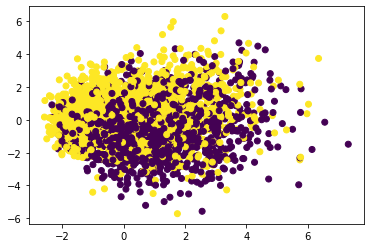

In [16]:
plt.scatter(plot_points[:, 0], plot_points[:, 1], c = comments[:, 1])

## Classify

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

**Balance Labels**

In [18]:
df = pd.DataFrame(doc_scaled)
df['label'] = np.array(comments[:, 1], dtype=int)

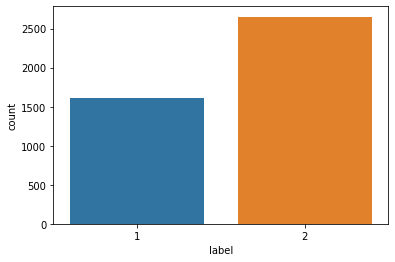

In [19]:
sns.countplot(df['label'])

In [20]:
df['label'].value_counts()

2    2652
1    1616
Name: label, dtype: int64

In [21]:
sampled_df = pd.concat([df[df['label'] == 2].sample(n=1616), df[df['label'] == 1]])

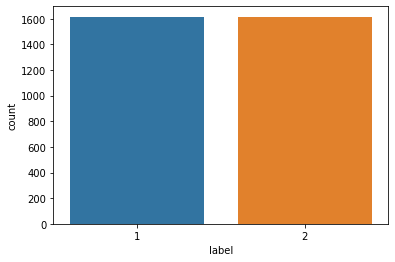

In [22]:
sns.countplot(sampled_df['label'])

In [23]:
sampled_df['label'].value_counts()

1    1616
2    1616
Name: label, dtype: int64

In [24]:
X = sampled_df.drop('label', axis=1)
y = sampled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

**Logistic Regression**

In [25]:
log = LogisticRegression()
log.fit(X_train, y_train)
pred = log.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[227  94]
 [ 66 260]]
0.7527047913446677


**Naive Bayes**

In [26]:
from sklearn.naive_bayes import GaussianNB

In [27]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[198 123]
 [ 84 242]]
0.6800618238021638


**Random Forest**

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[277  44]
 [115 211]]
0.7542503863987635


**Support Vector Machine**

In [30]:
from sklearn.svm import SVC

In [31]:
svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[273  48]
 [ 77 249]]
0.8068006182380216


## Finding Ideal Vector Size

Let's try and find which vector size gives us the best model!  Our approach is simple: create a new embedding model for each vector size and train base models.  We'll then plot the performance of each model as vector size increases.

In [32]:
performances = []

In [33]:
for i in range(1, 100):
    model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=i, min_count=2, epochs=100)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    doc_vectors = []
    for j in range(0, len(tagged_data)):
        doc_vectors.append(model[str(j)])

    doc_vectors = np.array(doc_vectors)
    scaler = StandardScaler()
    doc_scaled = scaler.fit_transform(doc_vectors)
    
    df = pd.DataFrame(doc_scaled)
    df['label'] = np.array(comments[:, 1], dtype=int)

    sampled_df = pd.concat([df[df['label'] == 2].sample(n=1616), df[df['label'] == 1]])
    X = sampled_df.drop('label', axis=1)
    y = sampled_df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
    
    log = LogisticRegression()
    log.fit(X_train, y_train)
    
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    
    forest = RandomForestClassifier()
    forest.fit(X_train, y_train)
    
    svc = SVC()
    svc.fit(X_train, y_train)
    
    performances.append([accuracy_score(y_test, log.predict(X_test)), 
                         accuracy_score(y_test, nb.predict(X_test)),
                         accuracy_score(y_test, forest.predict(X_test)),
                         accuracy_score(y_test, svc.predict(X_test))])

Text(0, 0.5, 'Accuracy')

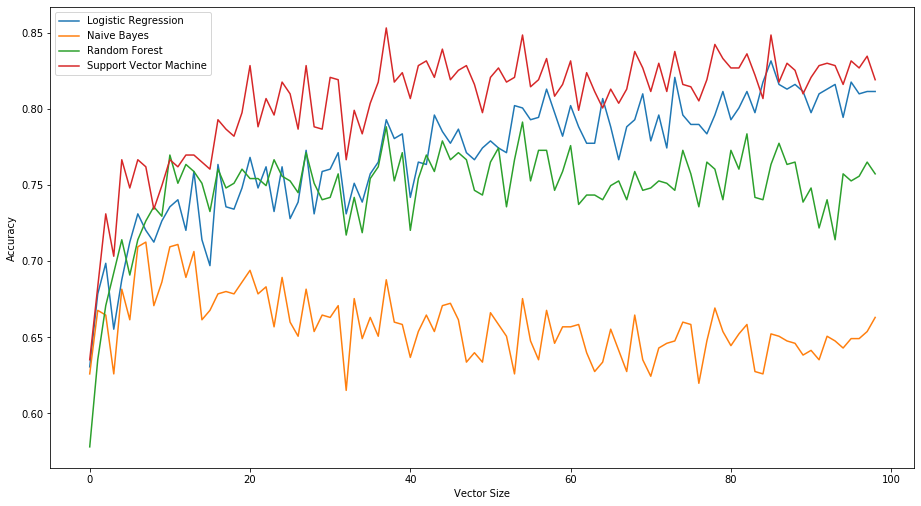

In [34]:
fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.plot(np.array(performances)[:, 0], label='Logistic Regression')
ax.plot(np.array(performances)[:, 1], label='Naive Bayes')
ax.plot(np.array(performances)[:, 2], label='Random Forest')
ax.plot(np.array(performances)[:, 3], label='Support Vector Machine')

ax.legend()
ax.set_xlabel('Vector Size')
ax.set_ylabel('Accuracy')

We can clearly see that Naive Bayes consistently performs the worst.  There is also a considerable loss of accuracy between vector sizes of 1 and about 10, and no really clear trends as vector size increases after that.  Accuracy tends to hover between 75% and 80%.  The highest accuracy is ~83%, achieved with a support vector machine.  Let's see where exactly this maximum occurs:

In [35]:
print(f'Highest accuracy: {round(max(np.array(performances).flatten()), 3)}%')

Highest accuracy: 0.853%


In [36]:
max_index = 0
for i in range(len(performances)):
    if max(performances[i]) > max(performances[max_index]):
        max_index = i

In [37]:
print(f'Vector size to yield maximum accuracy: {max_index}')

Vector size to yield maximum accuracy: 37
